# Learning to optimize parametric Quadratic Programming (pQP) using Neuromancer.

This is an interactive notebook based on the python script [Part_2_pQP.py](https://github.com/pnnl/neuromancer/blob/master/examples/parametric_programming/Part_2_pQP.py).  

Problem formulation pQP:
$$
    \begin{align}
    &\text{minimize } &&   x^2 + y^2\\
    &\text{subject to} &&  -x - y + p1 \le 0\\
    &  &&    x + y - p1 - 5 \le 0\\
    &  &&    x - y + p2 - 5 \le 0\\
    &  &&   -x + y - p2  \le 0\\
    \end{align}
$$

with parameters $p1, p2$ and decision variables $x, y$.

- https://colab.research.google.com/github/pnnl/neuromancer/blob/master/examples/parametric_programming/Part_2_pQP.ipynb#scrollTo=yD5kAnjy4CUL

### Import

In [ ]:
import cvxpy as cp
import numpy as np
import time
import torch
import torch.nn as nn
import neuromancer.slim as slim
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects

In [ ]:
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.constraint import variable
from neuromancer.dataset import DictDataset
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks
from neuromancer.system import Node

# Dataset

In [ ]:
data_seed = 408  # random seed used for simulated data
np.random.seed(data_seed)
torch.manual_seed(data_seed);

Randomly sample parameters from a uniform distribution: $1.0\le p1 \le11.0$;  $1.0\le p2 \le11.0$

In [ ]:
nsim = 3000  # number of datapoints: increase sample density for more robust results

# create dictionaries with sampled datapoints with uniform distribution
p_low, p_high = 1.0, 11.0
samples_train = {"p1": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high),
                 "p2": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high)}
samples_dev = {"p1": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high),
               "p2": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high)}
samples_test = {"p1": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high),
               "p2": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high)}

# create named dictionary datasets
train_data = DictDataset(samples_train, name='train')
dev_data = DictDataset(samples_dev, name='dev')
test_data = DictDataset(samples_test, name='test')

# create torch dataloaders for the Trainer
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, num_workers=0,
                                           collate_fn=train_data.collate_fn, shuffle=True)
dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=32, num_workers=0,
                                         collate_fn=dev_data.collate_fn, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, num_workers=0,
                                         collate_fn=test_data.collate_fn, shuffle=True)
# note: training quality will depend on the DataLoader parameters such as batch size and shuffle

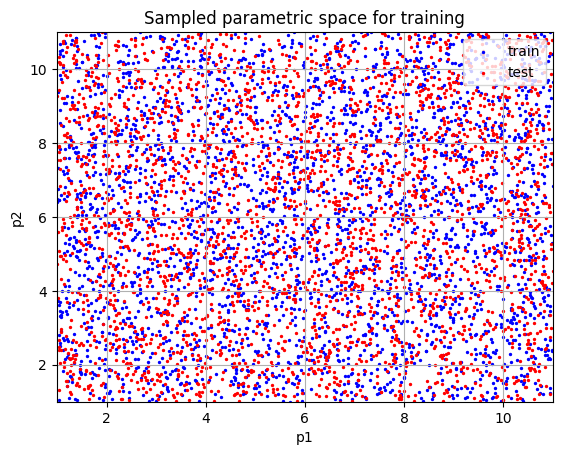

In [ ]:
# visualize taining and test samples for 2D parametric space
p1_train = samples_train['p1'].numpy()
p2_train = samples_train['p2'].numpy()
p1_dev = samples_dev['p1'].numpy()
p2_dev = samples_dev['p2'].numpy()
plt.figure()
plt.scatter(p1_train, p2_train, s=2., c='blue', marker='o')
plt.scatter(p1_dev, p2_dev, s=2., c='red', marker='o')
plt.title('Sampled parametric space for training')
plt.xlim(p_low, p_high)
plt.ylim(p_low, p_high)
plt.grid(True)
plt.xlabel('p1')
plt.ylabel('p2')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
plt.show(block=True)

# pQP Formulation in NeuroMANCER

## Primal Solution Map Architecture

In [ ]:
# define neural architecture for the solution map
func = blocks.MLP(insize=2, outsize=2,
                  bias=True,
                  linear_map=slim.maps['linear'],
                  nonlin=nn.ReLU,
                  hsizes=[80] * 4)

# wrap neural net into symbolic representation of the solution map via the Node class: sol_map(xi) -> x
sol_map = Node(func, ['p1', 'p2'], ['x'], name='map')

# trainable components of the problem solution
components = [sol_map]

## Objective and Constraints in NeuroMANCER

In [ ]:
"""
variable is a basic symbolic abstraction in Neuromancer
   x = variable("variable_name")                      (instantiates new variable)  
variable construction supports:
   algebraic expressions:     x**2 + x**3 + 5     (instantiates new variable)  
   slicing:                   x[:, i]             (instantiates new variable)  
   pytorch callables:         torch.sin(x)        (instantiates new variable)  
   constraints definition:    x <= 1.0            (instantiates Constraint object) 
   objective definition:      x.minimize()        (instantiates Objective object) 
to visualize computational graph of the variable use x.show() method          
"""

# variables
x = variable("x")[:, [0]]
y = variable("x")[:, [1]]
# sampled parameters
p1 = variable('p1')
p2 = variable('p2')

# objective function
f = x ** 2 + y ** 2
obj = f.minimize(weight=1.0, name='obj')
objectives = [obj]

# constraints
Q_con = 100.
g1 = -x - y + p1
con_1 = Q_con * (g1 <= 0)
con_1.name = 'c1'
# constraints for QP
g2 = x + y - p1 - 5
con_2 = Q_con*(g2 <= 0)
con_2.name = 'c2'
g3 = x - y + p2 - 5
con_3 = Q_con*(g3 <= 0)
con_3.name = 'c3'
g4 = -x + y - p2
con_4 = Q_con*(g4 <= 0)
con_4.name = 'c4'
constraints = [con_1, con_2, con_3, con_4]

In [ ]:
# create penalty method loss function
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(components, loss)

## Parametric Problem Solution in NeuroMANCER

In [ ]:
lr = 0.001      # step size for gradient descent
epochs = 400    # number of training epochs
warmup = 100    # number of epochs to wait before enacting early stopping policy
patience = 100  # number of epochs with no improvement in eval metric to allow before early stopping

In [ ]:
optimizer = torch.optim.AdamW(problem.parameters(), lr=lr)

# define trainer
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_loader,
    optimizer,
    epochs=epochs,
    patience=patience,
    warmup=warmup)

In [ ]:
# Train MLP solution map
best_model = trainer.train()
best_outputs = trainer.test(best_model)
# load best model dict
problem.load_state_dict(best_model)

epoch: 0  train_loss: 122.0165786743164
epoch: 1  train_loss: 32.599761962890625
epoch: 2  train_loss: 32.42778778076172
epoch: 3  train_loss: 31.82074546813965
epoch: 4  train_loss: 34.01682662963867
epoch: 5  train_loss: 32.4151725769043
epoch: 6  train_loss: 34.889774322509766
epoch: 7  train_loss: 32.63734817504883
epoch: 8  train_loss: 31.907119750976562
epoch: 9  train_loss: 32.113216400146484
epoch: 10  train_loss: 31.71891975402832
epoch: 11  train_loss: 30.254228591918945
epoch: 12  train_loss: 30.696016311645508
epoch: 13  train_loss: 30.477611541748047
epoch: 14  train_loss: 29.67075538635254
epoch: 15  train_loss: 30.368558883666992
epoch: 16  train_loss: 30.051889419555664
epoch: 17  train_loss: 29.98626136779785
epoch: 18  train_loss: 31.145029067993164
epoch: 19  train_loss: 31.92805290222168
epoch: 20  train_loss: 29.955080032348633
epoch: 21  train_loss: 29.84864616394043
epoch: 22  train_loss: 30.215065002441406
epoch: 23  train_loss: 28.873132705688477
epoch: 24  tra

<All keys matched successfully>

## Get a QP solution from CVXPY as a benchmark

[CVXPY](https://www.cvxpy.org/) is an open-source tool for constrained optimization that has influenced the development of NeuroMANCER.

In [ ]:
# Define the CVXPY problems.
def QP_param(p1, p2):
    x = cp.Variable(1)
    y = cp.Variable(1)
    prob = cp.Problem(cp.Minimize(x ** 2 + y ** 2),
                      [-x - y + p1 <= 0,
                       x + y - p1 - 5 <= 0,
                       x - y + p2 - 5 <= 0,
                       -x + y - p2 <= 0])
    return prob, x, y

## Compare: NeuroMANCER vs. CVXPY

parameter p=(2.0, 2.0)
primal solution CVXPY x=[1.], y=[1.]
primal solution Neuromancer x1=1.1509124040603638, x2=0.8680874109268188
parameter p=(3.0, 3.0)
primal solution CVXPY x=[1.5], y=[1.5]
primal solution Neuromancer x1=1.6031674146652222, x2=1.4022718667984009
parameter p=(4.0, 4.0)
primal solution CVXPY x=[2.], y=[2.]
primal solution Neuromancer x1=2.054532766342163, x2=1.9403698444366455
parameter p=(5.0, 5.0)
primal solution CVXPY x=[2.5], y=[2.5]
primal solution Neuromancer x1=2.417159080505371, x2=2.5803754329681396
parameter p=(6.0, 6.0)
primal solution CVXPY x=[2.5], y=[3.5]
primal solution Neuromancer x1=2.4758317470550537, x2=3.51680588722229
parameter p=(7.0, 7.0)
primal solution CVXPY x=[2.5], y=[4.5]
primal solution Neuromancer x1=2.4935407638549805, x2=4.491842269897461
parameter p=(8.0, 8.0)
primal solution CVXPY x=[2.5], y=[5.5]
primal solution Neuromancer x1=2.496649742126465, x2=5.481441497802734
parameter p=(9.0, 9.0)
primal solution CVXPY x=[2.5], y=[6.5]
prim

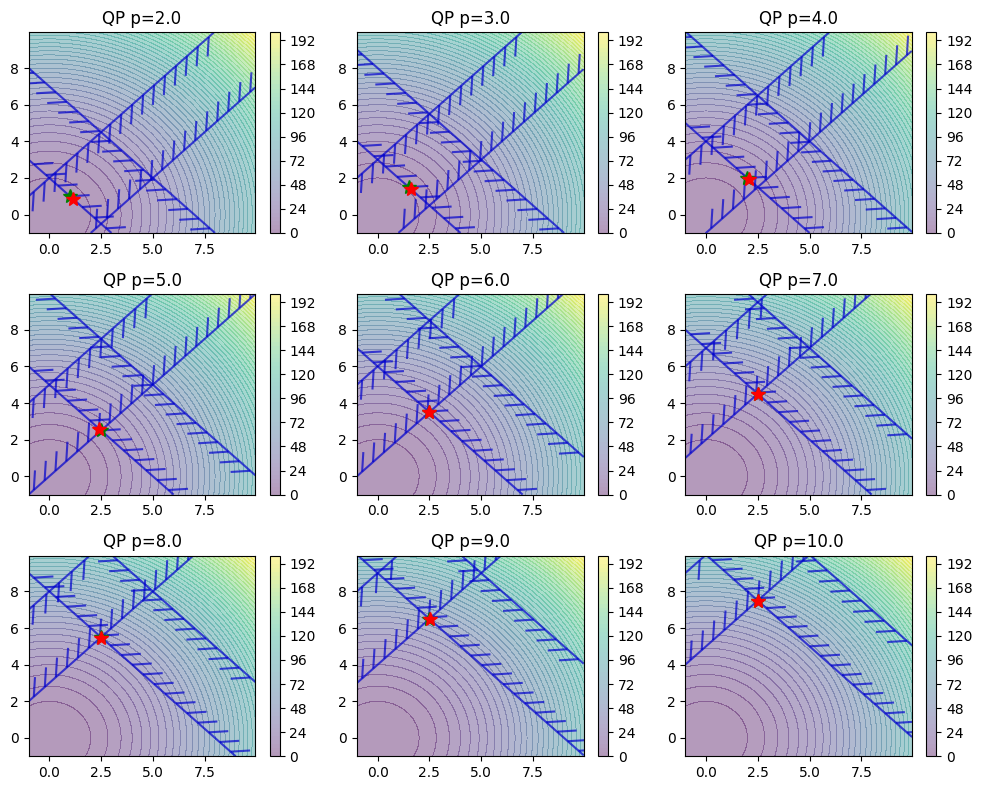

In [ ]:
"""
Plots
"""
# test problem parameters
params = [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
x1 = np.arange(-1.0, 10.0, 0.05)
y1 = np.arange(-1.0, 10.0, 0.05)
xx, yy = np.meshgrid(x1, y1)
fig, ax = plt.subplots(3,3, figsize=(10, 8))
row_id = 0
column_id = 0
for i, p in enumerate(params):
    if i % 3 == 0 and i != 0:
        row_id += 1
        column_id = 0

    # eval and plot objective and constraints
    J = xx ** 2 + yy ** 2
    cp_plot = ax[row_id, column_id].contourf(xx, yy, J, 50, alpha=0.4)
    ax[row_id, column_id].set_title(f'QP p={p}')
    # constraints for QP
    c1 = xx + yy - p
    c2 = -xx - yy + p + 5
    c3 = -xx + yy - p + 5
    c4 = xx - yy + p
    cg1 = ax[row_id, column_id].contour(xx, yy, c1, [0], colors='mediumblue', alpha=0.7)
    cg2 = ax[row_id, column_id].contour(xx, yy, c2, [0], colors='mediumblue', alpha=0.7)
    cg3 = ax[row_id, column_id].contour(xx, yy, c3, [0], colors='mediumblue', alpha=0.7)
    cg4 = ax[row_id, column_id].contour(xx, yy, c4, [0], colors='mediumblue', alpha=0.7)
    cg1.set(path_effects=[patheffects.withTickedStroke()], alpha=0.7)
    cg2.set(path_effects=[patheffects.withTickedStroke()], alpha=0.7)
    cg3.set(path_effects=[patheffects.withTickedStroke()], alpha=0.7)
    cg4.set(path_effects=[patheffects.withTickedStroke()], alpha=0.7)
    fig.colorbar(cp_plot, ax=ax[row_id,column_id])

    # Solve CVXPY problem
    prob, x, y = QP_param(p, p)
    prob.solve()

    # Solve via neuromancer
    datapoint = {'p1': torch.tensor([[p]]), 'p2': torch.tensor([[p]]),
                 'name': 'test'}
    model_out = problem(datapoint)
    x_nm = model_out['test_' + "x"][0, 0].detach().numpy()
    y_nm = model_out['test_' + "x"][0, 1].detach().numpy()

    print(f'parameter p={p, p}')
    print(f'primal solution CVXPY x={x.value}, y={y.value}')
    print(f'primal solution Neuromancer x1={x_nm}, x2={y_nm}')
    # print(f' f: {model_out["test_" + f.key]}')
    # print(f' g1: {model_out["test_" + g1.key]}')
    # print(f' g2: {model_out["test_" + g2.key]}')
    # print(f' g3: {model_out["test_" + g3.key]}')
    # print(f' g4: {model_out["test_" + g4.key]}')

    # Plot optimal solutions
    ax[row_id, column_id].plot(x.value, y.value, 'g*', markersize=10)
    ax[row_id, column_id].plot(x_nm, y_nm, 'r*', markersize=10)
    column_id += 1
plt.tight_layout()
plt.show()
plt.show(block=True)
plt.interactive(False)

# Green Star = CVXPY solution
# Red Star = Neuromancer solution

In [ ]:
"""
Benchmark Solution
"""

def eval_constraints(x, y, p1, p2):
    """
    evaluate mean constraints violations
    """
    con_1_viol = np.maximum(0, -x - y + p1)
    con_2_viol = np.maximum(0, x + y - p1 - 5)
    con_3_viol = np.maximum(0, x - y + p2 - 5)
    con_4_viol = np.maximum(0, -x + y - p2)
    con_viol = con_1_viol + con_2_viol + con_3_viol + con_4_viol
    con_viol_mean = np.mean(con_viol)
    return con_viol_mean

def eval_objective(x, y, a1=1, a2=1):
    obj_value_mean = np.mean(a1 * x**2 + a2 * y**2)
    return obj_value_mean

# Solve via neuromancer
t = time.time()
samples_test['name'] = 'test'
model_out = problem(samples_test)
nm_time = time.time() - t
x_nm = model_out['test_' + "x"][:, [0]].detach().numpy()
y_nm = model_out['test_' + "x"][:, [1]].detach().numpy()

# Solve via solver
t = time.time()
x_solver, y_solver = [], []
for i in range(0, nsim):
    p1 = samples_test['p1'][i].detach().numpy()
    p2 = samples_test['p2'][i].detach().numpy()
    prob, x, y = QP_param(p1, p2)
    prob.solve()
    x_solver.append(x.value)
    y_solver.append(y.value)
solver_time = time.time() - t
x_solver = np.asarray(x_solver)
y_solver = np.asarray(y_solver)

# Evaluate neuromancer solution
print(f'Solution for {nsim} problems via Neuromancer obtained in {nm_time:.4f} seconds')
nm_con_viol_mean = eval_constraints(x_nm, y_nm, p1, p2)
print(f'Neuromancer mean constraints violation {nm_con_viol_mean:.4f}')
nm_obj_mean = eval_objective(x_nm, y_nm)
print(f'Neuromancer mean objective value {nm_obj_mean:.4f}')

# Evaluate solver solution
print(f'Solution for {nsim} problems via solver obtained in {solver_time:.4f} seconds')
solver_con_viol_mean = eval_constraints(x_solver, y_solver, p1, p2)
print(f'Solver mean constraints violation {solver_con_viol_mean:.4f}')
solver_obj_mean = eval_objective(x_solver, y_solver)
print(f'Solver mean objective value {solver_obj_mean:.4f}')

# neuromancer solver comparison
speedup_factor = solver_time/nm_time
print(f'Solution speedup factor {speedup_factor:.4f}')

# Difference in primal optimizers
dx = (x_solver - x_nm)[:,0]
dy = (y_solver - y_nm)[:,0]
err_x = np.mean(dx**2)
err_y = np.mean(dy**2)
err_primal = err_x + err_y
print('MSE primal optimizers:', err_primal)

# Difference in objective
err_obj = np.abs(solver_obj_mean - nm_obj_mean) / solver_obj_mean * 100
print(f'mean objective value discrepancy: {err_obj:.2f} %')

# stats to log
stats = {"nsim": nsim,
         "nm_time": nm_time,
         "nm_con_viol_mean": nm_con_viol_mean,
         "nm_obj_mean": nm_obj_mean,
         "solver_time": solver_time,
         "solver_con_viol_mean": solver_con_viol_mean,
         "solver_obj_mean": solver_obj_mean,
         "speedup_factor": speedup_factor,
         "err_primal": err_primal,
         "err_obj": err_obj}

Solution for 3000 problems via Neuromancer obtained in 0.0049 seconds
Neuromancer mean constraints violation 2.2871
Neuromancer mean objective value 26.2284
Solution for 3000 problems via solver obtained in 20.4283 seconds
Solver mean constraints violation 2.3063
Solver mean objective value 26.2859
Solution speedup factor 4186.1694
MSE primal optimizers: 0.007501730904213855
mean objective value discrepancy: 0.22 %
